# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
%%capture
pip install matplotlib

In [2]:
%%capture
pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/s2/27yslc0j35s_xj4t3ln883cw0000gn/T/ipykernel_5582/555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
pd.set_option('display.max_columns', None)

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [5]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1414,I-2277221J,Hyundai Solaris,economy,petrol,4.92,2014,56415,2017,26.43,engine_fuel
558,L22673753u,VW Tiguan,economy,petrol,4.50,2013,40397,2020,29.57,gear_stick
445,n-1768418D,Nissan Qashqai,standart,petrol,4.86,2012,21071,2017,26.97,engine_fuel
806,v-1935966T,Hyundai Solaris,economy,petrol,4.70,2012,22882,2017,43.95,engine_overheat
905,Z56694596c,Nissan Qashqai,standart,petrol,4.24,2014,62465,2020,51.03,engine_check


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [6]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
30330,O10983772u,C-1092574s,g1F,2020-01-29,4.81,110,1756,44,74.000000,1,1180.604899,0,4.297224,-43.112
611637,a20129949O,r-4630038Z,c1S,2020-01-15,5.05,12,103,51,66.000000,1,98.880796,0,-7.834790,7.867
380846,u21212639e,b-1448976u,m1q,2020-03-12,4.96,60,833,43,106.000000,3,1731.525927,0,3.135203,-11.055
515699,d71443502d,k-7279260O,u1j,2020-03-13,1.68,34,403,83,152.402904,0,2137.438101,0,-14.139040,-7.481
532139,d18351268g,l13980749p,h1v,2020-01-26,5.10,13,177,73,110.807282,0,977.198506,0,-10.731576,21.986


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [7]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
13954,24,7.4,481,12.0,Q84213887r,1,2020-6-17
12413,50,8.0,81,NaN,f16139833d,0,2020-1-20
14837,38,8.3,161,25.0,W11437325W,1,2019-10-5
11401,51,7.5,1505,1.0,h17015069F,0,2021-6-11
4312,18,8.0,1018,15.0,i20575154Q,1,2020-11-8


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [8]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
29396,d22617101F,MT,2020-8-7 22:53,reparking,1.0,23
77775,t-1412384s,MD,2019-8-23 13:58,repair,5.8,16
138988,b77936061P,WP,2021-1-4 23:5,repair,4.5,11
107559,W18060288Q,QL,2020-2-19 12:12,repair,4.6,4
130098,J-2100035F,KG,2019-12-3 5:58,repair,4.8,14


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Создание признаков и объединение данных

Набор данных должен содержать только те признаки, которые позволят находить по задаче необходимые свойства, а точнее построить модели, способные решать задачи классификации, прогноза, и другого анализа. 

Итак, дано: 

3 набора данных у которых есть общие id поля. Разумнее их объединить сначала, что в целом получился у нас понятный датасет и мы могли сразу убрать мало интересующие нас признаки. 


In [9]:
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [10]:
rides_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            739500 non-null  object 
 1   car_id             739500 non-null  object 
 2   ride_id            739500 non-null  object 
 3   ride_date          739500 non-null  object 
 4   rating             739500 non-null  float64
 5   ride_duration      739500 non-null  int64  
 6   ride_cost          739500 non-null  int64  
 7   speed_avg          739500 non-null  int64  
 8   speed_max          736139 non-null  float64
 9   stop_times         739500 non-null  int64  
 10  distance           739500 non-null  float64
 11  refueling          739500 non-null  int64  
 12  user_ride_quality  736872 non-null  float64
 13  deviation_normal   739500 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 79.0+ MB


In [11]:
rides_info.describe()

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
count,739500.000000,739500.000000,7.395000e+05,739500.000000,736139.000000,739500.000000,7.395000e+05,739500.000000,736872.000000,739500.000000
mean,4.471255,1669.619079,2.093108e+04,47.012270,83.787431,1.337385,7.839567e+04,0.000004,-0.273648,-1.341434
std,2.130867,6356.635586,8.731537e+04,12.690333,29.642707,2.369775,3.158147e+05,0.002014,11.657122,19.581792
min,0.000000,2.000000,7.000000e+00,25.000000,27.900000,0.000000,1.843634e+00,0.000000,-65.776864,-126.883000
25%,3.120000,27.000000,2.980000e+02,38.000000,64.000000,0.000000,7.925952e+02,0.000000,-6.975054,-9.358000
50%,4.470000,44.000000,5.050000e+02,46.000000,75.275957,1.000000,1.452544e+03,0.000000,0.074098,0.000000
75%,5.830000,69.000000,8.880000e+02,52.000000,97.000000,2.000000,2.247795e+03,0.000000,6.461507,7.539250
max,10.000000,43956.000000,2.007346e+06,100.000000,209.982840,23.000000,3.606051e+06,1.000000,69.574650,98.743000


In [12]:
driver_info.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23


In [13]:
driver_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB


In [14]:
driver_info.describe()

,age,user_rating,user_rides,user_time_accident,sex
count,15153.000000,15153.000000,15153.000000,14182.000000,15153.000000
mean,33.581073,8.109345,871.015442,10.129601,0.499967
std,9.919271,0.668246,573.512378,8.867482,0.500016
min,18.000000,5.800000,0.000000,0.000000,0.000000
25%,25.000000,7.700000,421.000000,4.000000,0.000000
50%,33.000000,8.100000,876.000000,9.000000,0.000000
75%,41.000000,8.600000,1145.000000,14.000000,1.000000
max,63.000000,10.000000,3316.000000,86.000000,1.000000


In [15]:
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47


In [16]:
fix_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [17]:
fix_info.describe()

,destroy_degree,work_duration
count,146000.000000,146000.000000
mean,3.510022,26.144527
std,2.752983,12.642266
min,1.000000,1.000000
25%,1.000000,20.000000
50%,3.200000,26.000000
75%,5.500000,31.000000
max,10.000000,74.000000


Проведем группировку данных для каждой машины
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.
+ +общая заправка, общая стоимость поездок и общее количество остановок. 

In [18]:
aggregated_data = rides_info.groupby('car_id').agg(min_rating=pd.NamedAgg(column='rating', aggfunc='min'),
    avg_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
    max_speed=pd.NamedAgg(column='speed_max', aggfunc='max'),
    total_stop_times=pd.NamedAgg(column='stop_times', aggfunc='sum'),
    total_refueling=pd.NamedAgg(column='refueling', aggfunc='sum'),
    total_ride_cost=pd.NamedAgg(column='ride_cost', aggfunc='sum'),                                            
    total_trips=pd.NamedAgg(column='ride_id', aggfunc='count')).reset_index()

In [19]:
aggregated_data

,car_id,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips
0,A-1049127W,0.10,4.255172,1.125753e+07,179.729652,142,0,2645050,174
1,A-1079539w,0.10,4.088046,1.912765e+07,184.505566,144,0,4699301,174
2,A-1162143G,0.10,4.662299,2.995194e+06,180.000000,721,0,800344,174
3,A-1228282M,0.10,4.225172,1.793685e+07,182.446070,132,0,4764037,174
4,A-1339912r,0.10,4.690115,1.202552e+07,152.000000,155,0,2816285,174
...,...,...,...,...,...,...,...,...,...
4245,z73688663a,0.10,4.808448,1.113943e+07,165.000000,129,0,2708689,174
4246,z73740510r,0.28,4.699655,7.215961e+06,117.397405,622,0,2155613,174
4247,z86911952C,0.00,4.430977,2.135104e+07,173.428116,136,0,4697507,174
4248,z91353693Z,0.10,5.326092,1.614384e+07,106.089167,139,0,4834945,174


In [20]:
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [21]:
data = pd.merge(rides_info, aggregated_data, on='car_id', how = 'left')

In [22]:
data.shape

(739500, 22)

In [23]:
data = pd.merge(data, fix_info, on='car_id', how = 'left')

In [24]:
data.shape

(25404000, 27)

## Мерджинг увеличивает объем данных значительно. Пока не придумал как этого избежать. Из-за этого многие задания берут очень много времени для выполнения. 

In [25]:
data = pd.merge(data, driver_info, on='user_id', how = 'left')

In [26]:
data.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'total_trips', 'worker_id',
       'fix_date', 'work_type', 'destroy_degree', 'work_duration', 'age',
       'user_rating', 'user_rides', 'user_time_accident', 'sex',
       'first_ride_date'],
      dtype='object')

In [27]:
data.shape

(25404000, 33)

In [28]:
data.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips,worker_id,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,OO,2020-10-14 14:0,reparking,1.0,36,18,8.0,228,9.0,1,2019-9-16
1,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,SV,2019-6-27 16:56,refuel_check,1.0,31,18,8.0,228,9.0,1,2019-9-16
2,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,ZF,2019-5-9 16:51,refuel_check,1.0,32,18,8.0,228,9.0,1,2019-9-16
3,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,TY,2019-7-27 0:13,repair,7.5,44,18,8.0,228,9.0,1,2019-9-16
4,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,YV,2020-11-24 18:39,repair,5.9,23,18,8.0,228,9.0,1,2019-9-16


### Идеи для новых признаков

1.   Например, время которое прошло между первой поездкой и аварией
2.   Сколько заработала машина с учетом ремонта
3.   Средний ущерб для машины (максимальный, минимальный) 



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

На этот вопрос можно будет ответить, когда проверятся все гипотезы. Сначала поищем в том что есть. 

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25404000 entries, 0 to 25403999
Data columns (total 33 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   car_id              object 
 2   ride_id             object 
 3   ride_date           object 
 4   rating              float64
 5   ride_duration       int64  
 6   ride_cost           int64  
 7   speed_avg           int64  
 8   speed_max           float64
 9   stop_times          int64  
 10  distance            float64
 11  refueling           int64  
 12  user_ride_quality   float64
 13  deviation_normal    float64
 14  min_rating          float64
 15  avg_rating          float64
 16  total_distance      float64
 17  max_speed           float64
 18  total_stop_times    int64  
 19  total_refueling     int64  
 20  total_ride_cost     int64  
 21  total_trips         int64  
 22  worker_id           object 
 23  fix_date            object 
 24  work_type           ob

In [30]:
data.head(2)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips,worker_id,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,OO,2020-10-14 14:0,reparking,1.0,36,18,8.0,228,9.0,1,2019-9-16
1,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,SV,2019-6-27 16:56,refuel_check,1.0,31,18,8.0,228,9.0,1,2019-9-16


In [31]:
#Удаляем константы из датасета
constant_columns = data.columns[data.nunique() <= 1]
data = data.drop(columns=constant_columns)

In [32]:
data.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'worker_id', 'fix_date',
       'work_type', 'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date'],
      dtype='object')

In [33]:
#Удаляем колонки с id
data = data [['ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'fix_date',
       'work_type', 'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date']]

In [34]:
data.tail(5)

,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
25403995,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-9-28 16:54,repair,3.6,5,21,7.0,193,0.0,1,2020-4-4
25403996,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-11-23 8:36,reparking,1.0,26,21,7.0,193,0.0,1,2020-4-4
25403997,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-6-29 23:5,repair,3.8,1,21,7.0,193,0.0,1,2020-4-4
25403998,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2019-2-18 18:41,refuel,1.0,30,21,7.0,193,0.0,1,2020-4-4
25403999,2020-04-01,5.96,29,344,45,55.0,2,1140.454305,0,NaN,-50.835,0.1,4.307471,7.453857e+06,108.653269,130,0,1682118,2021-5-27 16:22,refuel_check,1.0,29,21,7.0,193,0.0,1,2020-4-4


In [35]:
#Половой признак, возраст скорей всего никак не влияет на решение задачи для нас
numeric_columns = ['ride_duration',
       'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 
       'user_rides', 'user_time_accident']
categorial_columns = ['work_type']
date_columns = ['ride_date', 'fix_date', 'first_ride_date']

In [36]:
correlation_matrix = data[numeric_columns].corr()

<Axes: >

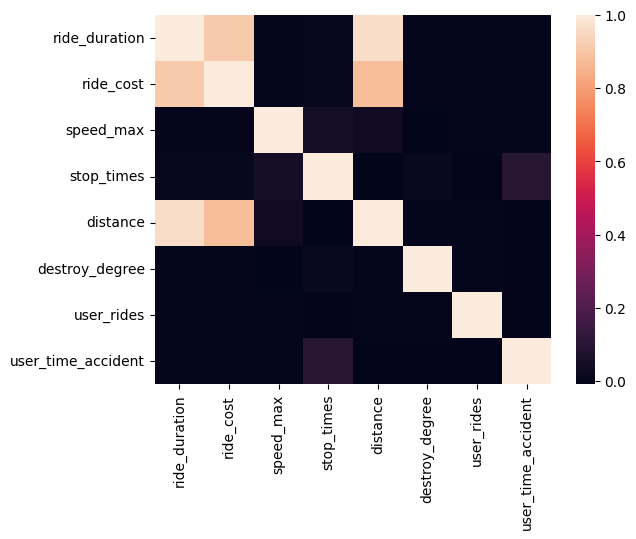

In [37]:
sns.heatmap(correlation_matrix)

In [38]:
correlation_matrix

,ride_duration,ride_cost,speed_max,stop_times,distance,destroy_degree,user_rides,user_time_accident
ride_duration,1.000000,0.912823,0.001141,0.009082,0.964464,0.000350,0.000037,-0.000517
ride_cost,0.912823,1.000000,0.000699,0.006922,0.880827,0.000177,0.001962,0.001021
speed_max,0.001141,0.000699,1.000000,0.048341,0.033203,-0.009106,-0.000954,0.001687
stop_times,0.009082,0.006922,0.048341,1.000000,-0.007986,0.011540,-0.002371,0.093600
distance,0.964464,0.880827,0.033203,-0.007986,1.000000,0.000023,-0.000135,-0.002469
destroy_degree,0.000350,0.000177,-0.009106,0.011540,0.000023,1.000000,0.000138,-0.003596
user_rides,0.000037,0.001962,-0.000954,-0.002371,-0.000135,0.000138,1.000000,-0.003418
user_time_accident,-0.000517,0.001021,0.001687,0.093600,-0.002469,-0.003596,-0.003418,1.000000


In [39]:
abs_corr_matrix = correlation_matrix.abs()
sorted_pairs = abs_corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
unique_sorted_pairs = sorted_pairs.drop_duplicates()
top4_pairs = unique_sorted_pairs[1:10] 

print(top4_pairs)

ride_duration   distance              0.964464
ride_cost       ride_duration         0.912823
                distance              0.880827
stop_times      user_time_accident    0.093600
                speed_max             0.048341
distance        speed_max             0.033203
destroy_degree  stop_times            0.011540
speed_max       destroy_degree        0.009106
stop_times      ride_duration         0.009082
dtype: float64


 # В общем данных много. Надо сделать меньше набор данных, чтобы можно было выполнить задание. В дальнейшем в работе когда дойдем до конца, и будет возможность взять мощнее оборудование, прогоним на полном наборе данных.

In [40]:
data = data [numeric_columns+categorial_columns]

In [41]:
data.shape

(25404000, 9)

In [42]:
full_data = data.copy()

In [43]:
sample_size = 1000

data = data.sample(n=sample_size, replace=False, random_state=123)

In [44]:
data.shape

(1000, 9)

In [45]:
%%capture
pip install phik

In [46]:
#долго работает код, в целом дает ли он какое-то представление о корреляции?
import phik
from phik import resources, report

phik_matrix = data.phik_matrix(interval_cols = numeric_columns)

interval columns not set, guessing: ['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance', 'destroy_degree', 'user_rides', 'user_time_accident']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/phik/outliers.py:200: RuntimeWarning: invalid value encountered in scalar subtract
  logmidp = np.log(0.5) + lp + np.log(1 + np.exp(lp1 - lp))


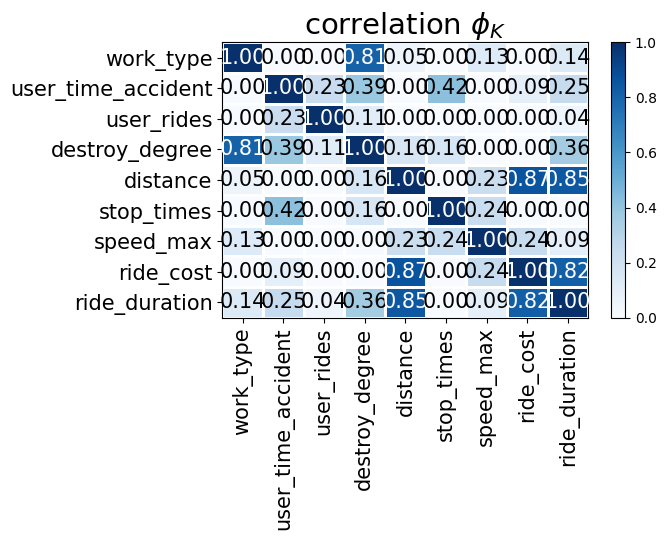

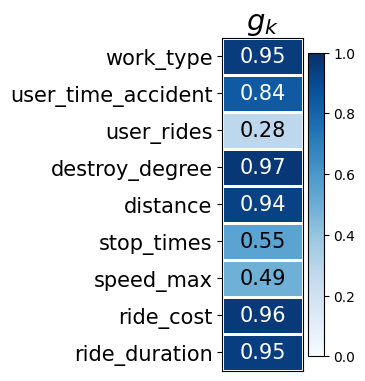

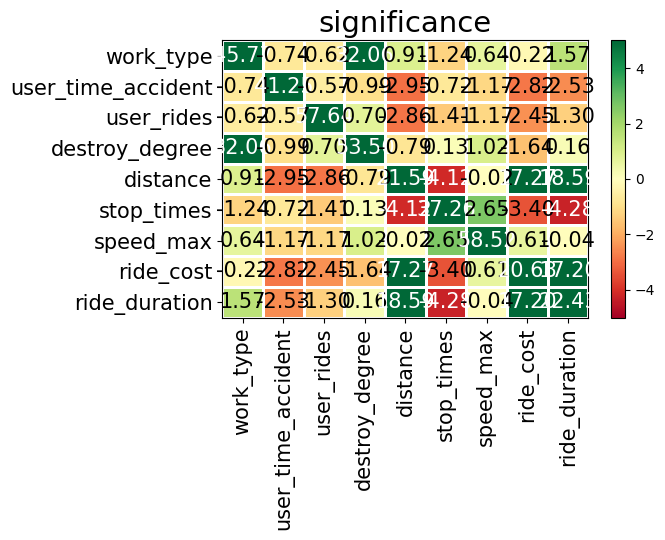

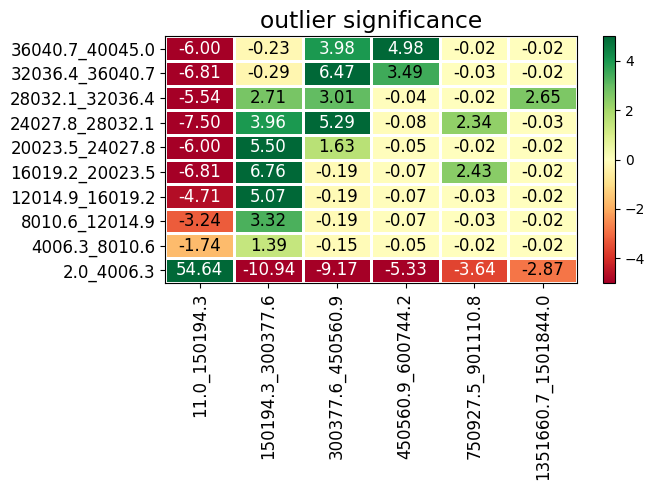

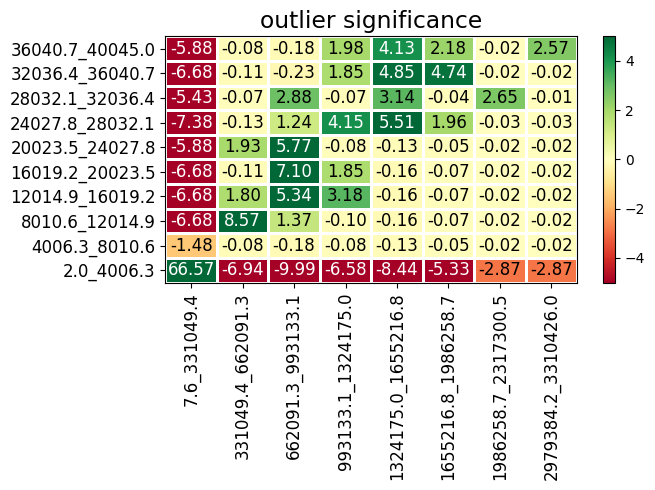

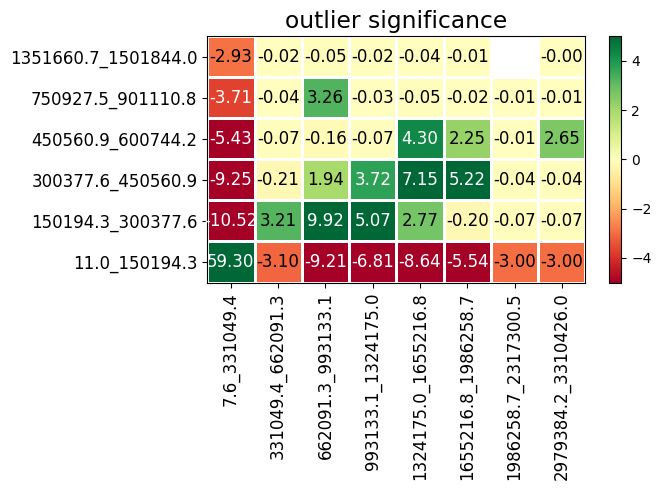

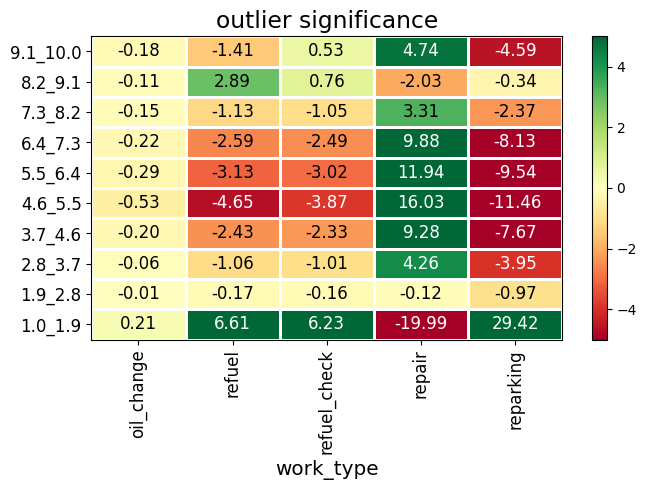

In [47]:
from phik import report
rep = report.correlation_report(data, significance_threshold=3, correlation_threshold=0.5)

In [48]:
import itertools

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

%matplotlib inline

In [49]:
# bin the interval variables
data_binned, binning_dict = bin_data(data, cols=numeric_columns, retbins=True)

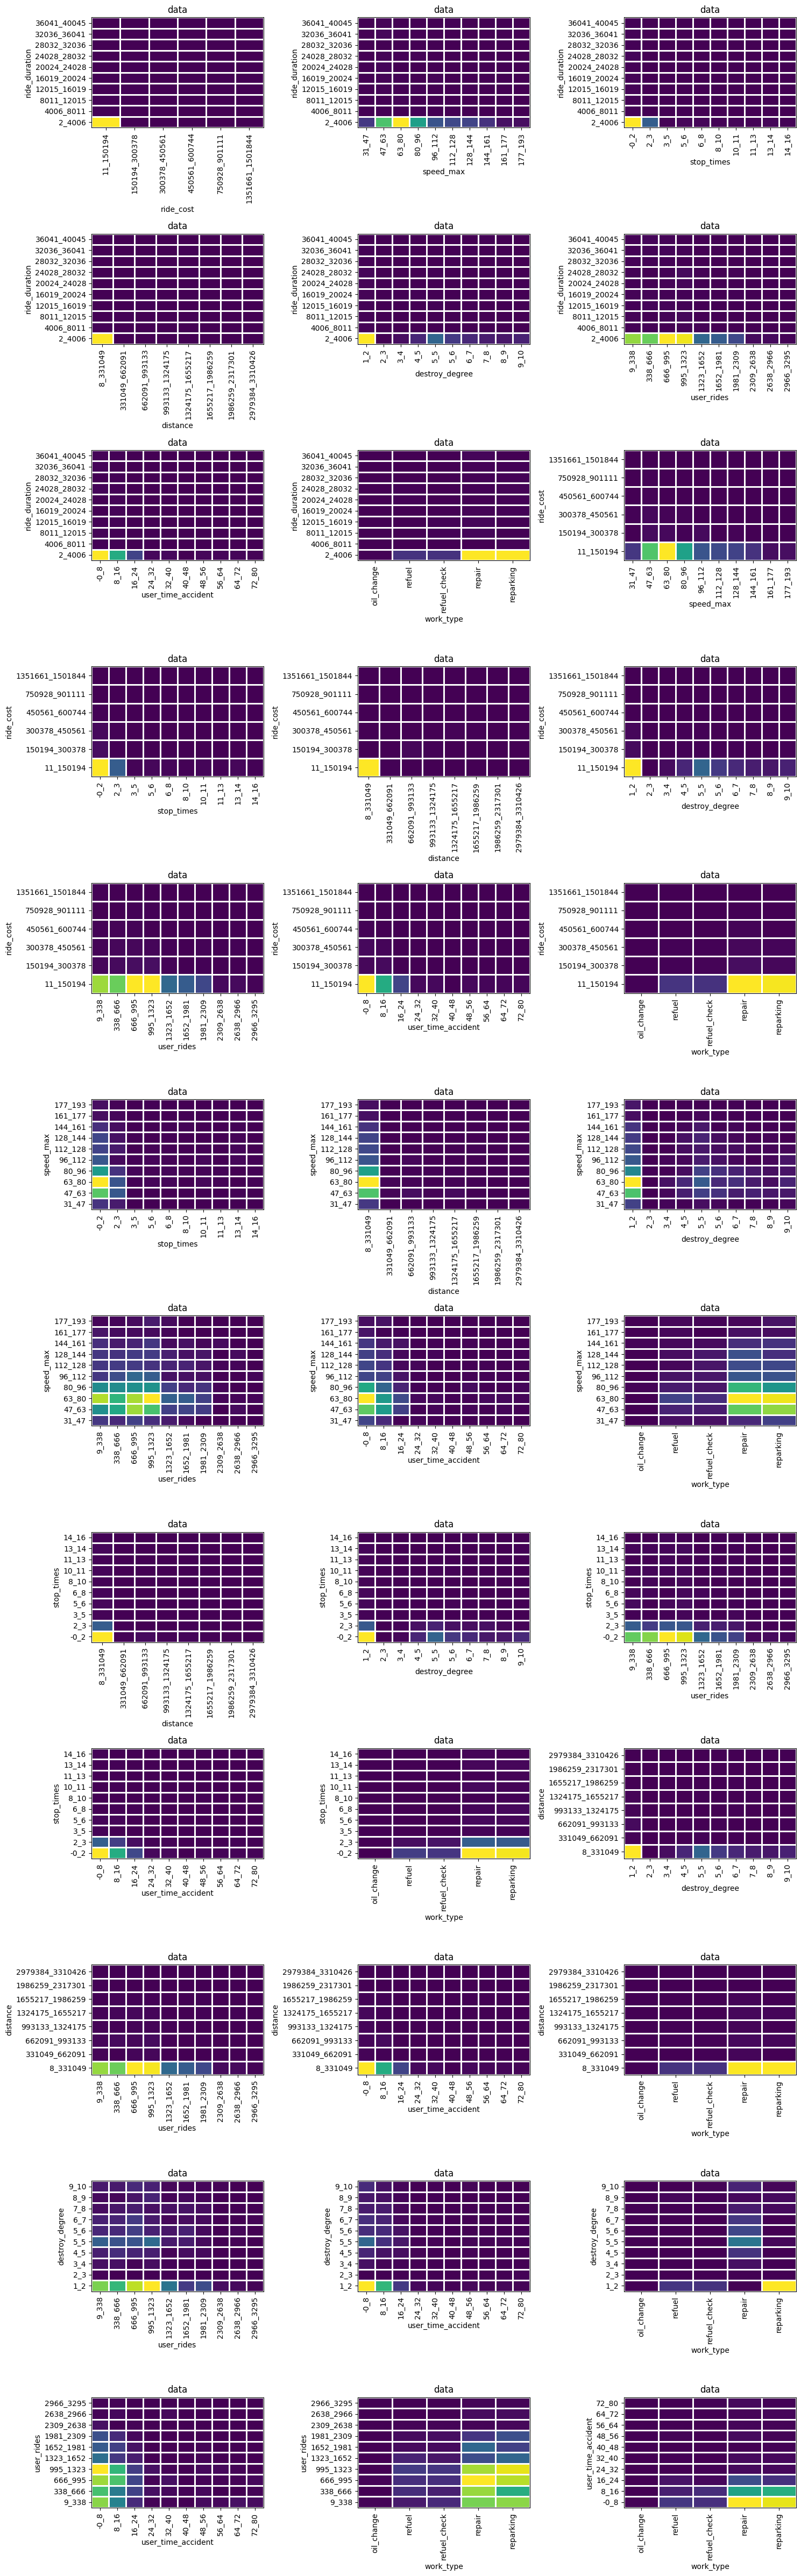

In [50]:
plt.rc('text', usetex=False)

n=0
for i in range(len(data.columns)):
    n=n+i
    
ncols=3
nrows=int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # get data
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # plot data
    img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
    # axis ticks and tick labels
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # axis labels
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical')
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
    axes[r][c].set_xlabel(datahist.columns.name)
    axes[r][c].set_ylabel(datahist.index.name)    
    axes[r][c].set_title('data')
    
plt.tight_layout()

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

train_data = data[numeric_columns+categorial_columns]

rf_model = RandomForestClassifier().fit(train_data.drop('work_type', axis=1), train_data['work_type'])
result = permutation_importance(rf_model, train_data.drop('work_type', axis=1), train_data['work_type'], n_repeats=10)
perm_sorted_idx = result.importances_mean.argsort()

In [52]:
import numpy as np

# Получить имена признаков из датафрейма train_data
feature_names = train_data.drop('work_type', axis=1).columns

# Получить упорядоченные имена признаков по их важности
sorted_feature_names = feature_names[perm_sorted_idx]

# Вывести упорядоченные имена признаков с их важностью
for name, importance in zip(sorted_feature_names, result.importances_mean[perm_sorted_idx]):
    print(f'{name}: {importance}')

stop_times: 0.03480000000000003
ride_cost: 0.06369999999999998
user_rides: 0.06669999999999998
ride_duration: 0.06799999999999998
speed_max: 0.07159999999999997
user_time_accident: 0.07559999999999996
distance: 0.08659999999999997
destroy_degree: 0.49219999999999997


In [53]:
%%capture
pip install shap

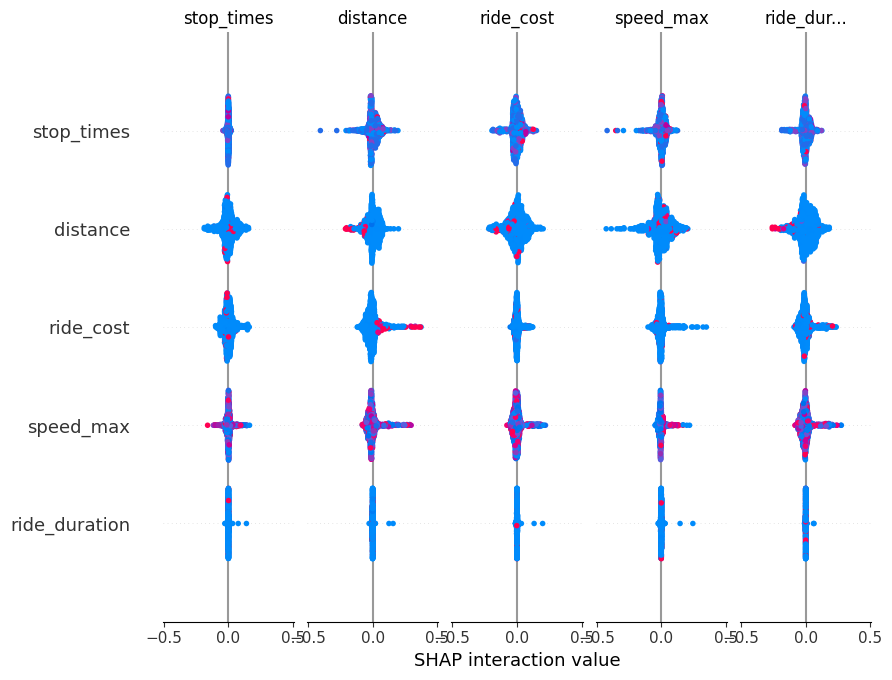

In [54]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(train_data.drop('work_type', axis=1))

shap.summary_plot(shap_values, train_data.drop('work_type', axis=1))

Распределение точек вдоль оси x (SHAP значения) показывает, насколько велико влияние признака на прогноз. Например, если большинство точек признака distance сгруппированы вокруг положительных значений SHAP, это может означать, что большее расстояние увеличивает вероятность прогнозируемого исхода. Наличие точек как с положительными, так и с отрицательными значениями SHAP для одного признака может указывать на более сложное взаимодействие этого признака с исходом в различных условиях.

In [55]:
%%capture
pip install catboost

In [56]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(iterations=100, verbose=False)
cat_model.fit(train_data.drop('work_type', axis=1), train_data['work_type'])
feature_importances = cat_model.get_feature_importance(Pool(train_data.drop('work_type', axis=1), train_data['work_type']))

feature_names = train_data.drop('work_type', axis=1).columns
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)

              Feature  Importance
5      destroy_degree   50.845662
2           speed_max    9.530070
6          user_rides    8.599073
7  user_time_accident    7.892611
3          stop_times    6.367210
4            distance    6.126074
0       ride_duration    5.907105
1           ride_cost    4.732193


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [57]:
features2drop = [...] # то, что надо выбросить
targets = ['work_type'] # таргеты
cat_features = ['work_type'] # категориальные признаки

num_features = ['ride_duration',
       'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 
       'user_rides', 'user_time_accident'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 ['work_type']
Числовые признаки: 8 ['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance', 'destroy_degree', 'user_rides', 'user_time_accident']
Целевые переменные ['work_type']


In [58]:
data[targets].value_counts()

work_type   
repair          440
reparking       424
refuel           69
refuel_check     65
oil_change        2
Name: count, dtype: int64

Accuracy: 0.825


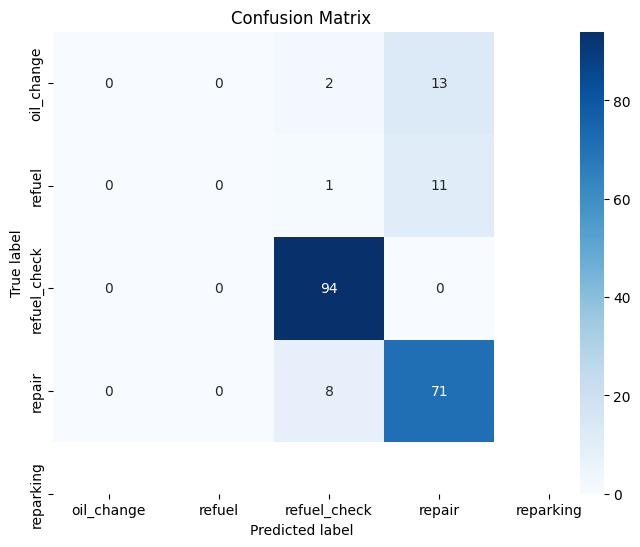

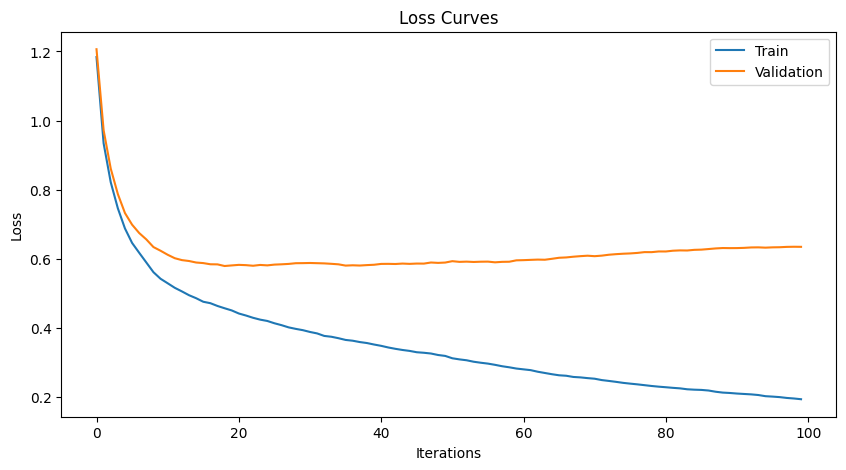

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming `data`, `num_features`, and `targets` are predefined
X = data[num_features]
y = data[targets]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize and fit the model
cat_model = CatBoostClassifier(iterations=100, verbose=False)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

# Get the training and validation metrics
train_metrics = cat_model.get_evals_result()
train_loss = train_metrics['learn']['MultiClass']  # Make sure 'MultiClass' matches your loss metric
val_loss = train_metrics['validation']['MultiClass']  # Corrected key for validation metrics

# Model evaluation
y_pred = cat_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

              precision    recall  f1-score   support

      refuel       0.00      0.00      0.00        15
refuel_check       0.00      0.00      0.00        12
      repair       0.90      1.00      0.94        94
   reparking       0.75      0.90      0.82        79

    accuracy                           0.82       200
   macro avg       0.41      0.47      0.44       200
weighted avg       0.72      0.82      0.77       200



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

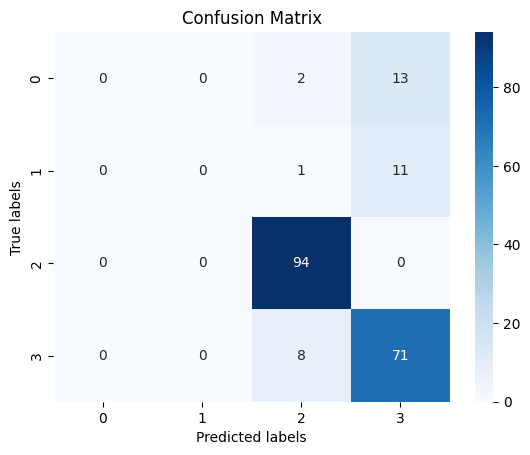

In [60]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns

#Генерация classification_report
y_pred = cat_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

#Построение и визуализация матрицы 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


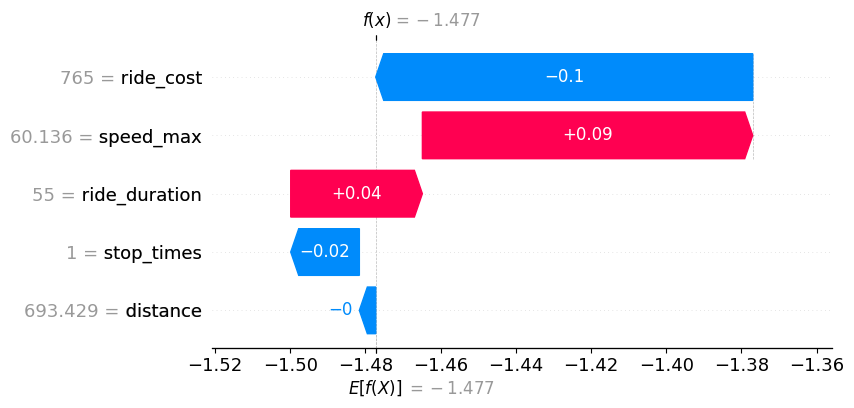

In [61]:
explainer = shap.Explainer(cat_model)
shap_values = explainer.shap_values(X)
class_index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[class_index][0], base_values=explainer.expected_value[class_index], data=X.iloc[0]), max_display=20)

plt.show()

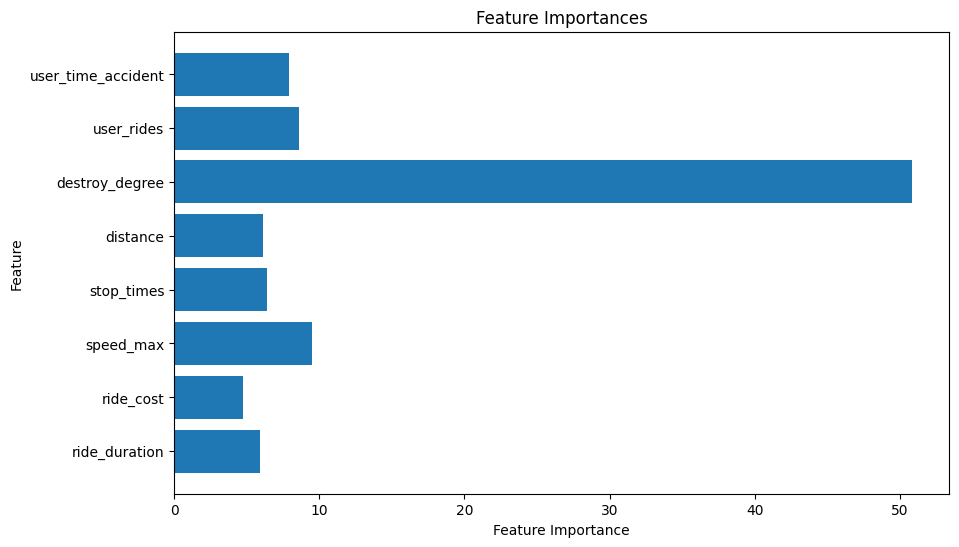

In [62]:
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [63]:
#pip install optuna

### С полными данными

In [64]:
full_data.head()

,ride_duration,ride_cost,speed_max,stop_times,distance,destroy_degree,user_rides,user_time_accident,work_type
0,21,268,113.548538,0,514.24692,1.0,228,9.0,reparking
1,21,268,113.548538,0,514.24692,1.0,228,9.0,refuel_check
2,21,268,113.548538,0,514.24692,1.0,228,9.0,refuel_check
3,21,268,113.548538,0,514.24692,7.5,228,9.0,repair
4,21,268,113.548538,0,514.24692,5.9,228,9.0,repair


In [65]:
full_data.shape

(25404000, 9)

In [66]:
full_data.columns

Index(['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 'user_rides', 'user_time_accident', 'work_type'],
      dtype='object')

In [67]:
# Обучение занимает достаточно количество времени, поэтому уменьшаем размер. Но можно и поставить полный размер данных. 
#Тогда результат будет приближен к задаче. 

sample_size = 100000

data_100000 = full_data.sample(n=sample_size, replace=False, random_state=123)

In [68]:
X = data_100000[['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 'user_rides', 'user_time_accident']]
y = data_100000[['work_type']]

In [69]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [70]:
import optuna
from catboost import CatBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [71]:
def objective(trial):
    # Гиперпараметры для подбора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),

        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [72]:
# Создание объекта study
study = optuna.create_study(direction='maximize')

# Оптимизация
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

# Сохранение гиперпараметров лучшей модели
best_params = trial.params


print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-31 16:21:22,363] A new study created in memory with name: no-name-4839b157-fd97-41af-bd15-aac0d15a79c3
[I 2024-03-31 16:21:26,456] Trial 0 finished with value: 0.8642 and parameters: {'iterations': 271, 'depth': 8, 'learning_rate': 0.01177406230981058, 'l2_leaf_reg': 0.06417210585965868, 'border_count': 79}. Best is trial 0 with value: 0.8642.
[I 2024-03-31 16:21:41,764] Trial 1 finished with value: 0.8531 and parameters: {'iterations': 733, 'depth': 9, 'learning_rate': 0.34270641448097555, 'l2_leaf_reg': 1.6904182387680298, 'border_count': 250}. Best is trial 0 with value: 0.8642.
[I 2024-03-31 16:21:44,961] Trial 2 finished with value: 0.8645 and parameters: {'iterations': 450, 'depth': 4, 'learning_rate': 0.04275186619595686, 'l2_leaf_reg': 0.001962447377444059, 'border_count': 224}. Best is trial 2 with value: 0.8645.
[I 2024-03-31 16:21:54,086] Trial 3 finished with value: 0.8622 and parameters: {'iterations': 589, 'depth': 8, 'learning_rate': 0.11555794050500892, 'l2_l

Best trial:
  Value:  0.8646
  Params: 
    iterations: 916
    depth: 4
    learning_rate: 0.02488382567701105
    l2_leaf_reg: 0.024157150579065482
    border_count: 116


In [73]:
# Обучение модели CatBoostClassifier на базовых гиперпараметрах
base_model = CatBoostClassifier(verbose=False)
base_model.fit(X_train, y_train)

# Обучение модели CatBoostClassifier на подобранных гиперпараметрах
best_model = CatBoostClassifier(verbose=False, **best_params)
best_model.fit(X_train, y_train)

# Сравнение двух моделей
y_pred_base = base_model.predict(X_test)
accuracy_base = accuracy_score(y_test, y_pred_base)

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

print("\nAccuracy на базовых гиперпараметрах:", accuracy_base)
print("Accuracy на подобранных гиперпараметрах:", accuracy_best)


Accuracy на базовых гиперпараметрах: 0.8641
Accuracy на подобранных гиперпараметрах: 0.8646


### Выводы

В результате проведенных экспериментов подобранные гиперпараметры показывают более высокую точность.

- модель теперь больше соответствует данным
- модель обучается оптимальнее и быстрее
- мы можем интерпретировать некоторые особенности выполненной задачи

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [74]:
#pip install setuptools

In [75]:
#pip install xgboost

In [76]:
#pip install catboost

In [77]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from scipy.stats import mode
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import numpy as np

## DATA

In [78]:
sample_size = 100000
data_100000 = full_data.sample(n=sample_size, replace=False, random_state=123)
X = data_100000[['ride_duration', 'ride_cost', 'speed_max', 'stop_times', 'distance',
       'destroy_degree', 'user_rides', 'user_time_accident']]
y = data_100000[['work_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Преобразование строковых меток в числовые
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train).ravel()
y_test_encoded = label_encoder.transform(y_test).ravel()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## CATBOOST

In [96]:
# Определение функции objective для подбора гиперпараметров CatBoostClassifier
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Создание объекта study для CatBoostClassifier
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=50)

# Получение лучших гиперпараметров CatBoostClassifier
best_params_catboost = study_catboost.best_params

# Обучение CatBoostClassifier с лучшими гиперпараметрами
best_model_catboost = CatBoostClassifier(**best_params_catboost)
best_model_catboost.fit(X_train, y_train)


[I 2024-03-31 17:24:11,401] A new study created in memory with name: no-name-193e2143-b6b4-4b24-963e-b077726de901
[I 2024-03-31 17:24:36,628] Trial 0 finished with value: 0.86415 and parameters: {'iterations': 886, 'depth': 10, 'learning_rate': 0.026061399521289053, 'l2_leaf_reg': 8.145674395133447, 'border_count': 198}. Best is trial 0 with value: 0.86415.
[I 2024-03-31 17:24:53,181] Trial 1 finished with value: 0.8619 and parameters: {'iterations': 661, 'depth': 10, 'learning_rate': 0.17470457872427989, 'l2_leaf_reg': 7.164207876881864, 'border_count': 139}. Best is trial 0 with value: 0.86415.
[I 2024-03-31 17:24:58,399] Trial 2 finished with value: 0.86455 and parameters: {'iterations': 577, 'depth': 6, 'learning_rate': 0.05325771186259555, 'l2_leaf_reg': 2.9079392188561592, 'border_count': 201}. Best is trial 2 with value: 0.86455.
[I 2024-03-31 17:25:05,233] Trial 3 finished with value: 0.8644 and parameters: {'iterations': 458, 'depth': 8, 'learning_rate': 0.08088483438295328, '

0:	learn: 1.0607037	total: 7.26ms	remaining: 726ms
1:	learn: 0.8535307	total: 14.9ms	remaining: 738ms
2:	learn: 0.7382471	total: 22.7ms	remaining: 741ms
3:	learn: 0.6586840	total: 30.6ms	remaining: 742ms
4:	learn: 0.6047394	total: 38.4ms	remaining: 737ms
5:	learn: 0.5666806	total: 45.9ms	remaining: 727ms
6:	learn: 0.5402726	total: 53.1ms	remaining: 713ms
7:	learn: 0.5188974	total: 60.5ms	remaining: 703ms
8:	learn: 0.5054225	total: 69.2ms	remaining: 708ms
9:	learn: 0.4932523	total: 76.3ms	remaining: 694ms
10:	learn: 0.4850782	total: 84ms	remaining: 687ms
11:	learn: 0.4774842	total: 91.8ms	remaining: 681ms
12:	learn: 0.4718965	total: 98.9ms	remaining: 670ms
13:	learn: 0.4671851	total: 105ms	remaining: 655ms
14:	learn: 0.4632972	total: 112ms	remaining: 641ms
15:	learn: 0.4585177	total: 120ms	remaining: 636ms
16:	learn: 0.4561887	total: 126ms	remaining: 625ms
17:	learn: 0.4546235	total: 133ms	remaining: 612ms
18:	learn: 0.4529680	total: 140ms	remaining: 606ms
19:	learn: 0.4510744	total: 14

## XGBOOST

In [97]:
# Определение функции objective для подбора гиперпараметров XGBClassifier (DART)
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'tree_method': 'hist',
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train_encoded)),  # Автоматическое определение количества классов
        'verbosity': 0
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return accuracy

# Создание объекта study для XGBClassifier (DART)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

# Получение лучших гиперпараметров XGBClassifier (DART)
best_params_xgb = study_xgb.best_params

# Обучение XGBClassifier (DART) с лучшими гиперпараметрами
best_model_xgb = XGBClassifier(**best_params_xgb, booster='dart', tree_method='hist', objective='multi:softmax', num_class=3)
best_model_xgb.fit(X_train, y_train_encoded)

[I 2024-03-31 17:28:42,414] A new study created in memory with name: no-name-e641131c-a503-4538-9f9b-89722b29ba3f
[I 2024-03-31 17:28:43,097] Trial 0 finished with value: 0.8646 and parameters: {'max_depth': 4, 'learning_rate': 0.06474560642327765, 'subsample': 0.6000688021815885, 'colsample_bytree': 0.9921791412106105, 'gamma': 0.41221323851180625, 'lambda': 0.31585699962197883, 'alpha': 0.4943655478554849}. Best is trial 0 with value: 0.8646.
[I 2024-03-31 17:28:43,748] Trial 1 finished with value: 0.86265 and parameters: {'max_depth': 10, 'learning_rate': 0.36206244191184805, 'subsample': 0.7698622300097099, 'colsample_bytree': 0.5031138153547459, 'gamma': 0.8162443427985464, 'lambda': 0.1163341243127509, 'alpha': 0.6074754274356439}. Best is trial 0 with value: 0.8646.
[I 2024-03-31 17:28:44,894] Trial 2 finished with value: 0.8645 and parameters: {'max_depth': 9, 'learning_rate': 0.011258772285987392, 'subsample': 0.8325158303340149, 'colsample_bytree': 0.9612194286486375, 'gamma'

XGBClassifier(alpha=0.4943655478554849, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9921791412106105, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.41221323851180625,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.31585699962197883,
              learning_rate=0.06474560642327765, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

 ## RANDOM FOREST

In [98]:
# Определяем базовую модель
base_model_rf = RandomForestClassifier(random_state=42)

# Определяем сетку гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20],      # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество выборок, необходимое для разделения узла
    'min_samples_leaf': [1, 2, 4],    # Минимальное количество выборок, требуемое в листе
    'bootstrap': [True, False]        # Использование бутстрап-выборок
}

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(estimator=base_model_rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Подгоняем GridSearchCV
grid_search.fit(X_train, y_train_encoded)

# Выводим наилучшие параметры
print("Best parameters:", grid_search.best_params_)

# Обучаем модель на лучших параметрах
best_model_rf = grid_search.best_estimator_
best_model_rf.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [99]:
# Оценка качества каждой модели
best_model_rf_score = best_model_rf.score(X_test, y_test_encoded)
best_model_catboost_score = best_model_catboost.score(X_test, y_test_encoded)
best_model_xgb_score = best_model_xgb.score(X_test, y_test_encoded)

print("Optimized RandomForestClassifier accuracy:", best_model_rf_score)
print("Optimized CatBoostClassifier accuracy:", best_model_catboost_score)
print("Optimized XGBClassifier accuracy:", best_model_xgb_score)

CatBoostError: predicted classes have string type but specified y is numeric

In [ ]:
# Инициализация моделей
best_model_catboost = CatBoostClassifier(**best_model_catboost.get_params())
best_model_rf.fit(X_train, y_train_encoded)
best_model_catboost.fit(X_train, y_train_encoded)
best_model_xgb.fit(X_train, y_train_encoded)

# Обучение базовых моделей и проверка формы их предсказаний
models = [best_model_rf, best_model_catboost, best_model_xgb]
for model in models:
    y_pred = model.predict(X_test)
    print(f"{model.__class__.__name__} prediction shape: {y_pred.shape}")
    print(f"Unique labels in {model.__class__.__name__} prediction: {np.unique(y_pred)}")

# Реализация Hard Voting
voting_hard = VotingClassifier(estimators=[
    ('rf', best_model_rf),
    ('catboost', best_model_catboost),  # Используем обернутую версию
    ('xgb', best_model_xgb)
], voting='hard')

voting_hard.fit(X_train, y_train_encoded)
voting_hard_score = voting_hard.score(X_test, y_test_encoded)
print("Hard Voting accuracy:", voting_hard_score)

# Реализация Soft Voting
voting_soft = VotingClassifier(estimators=[
    ('rf', best_model_rf),
    ('catboost', custom_catboost),  # Используем обернутую версию
    ('xgb', best_model_xgb)
], voting='soft')

voting_soft.fit(X_train, y_train_encoded)
soft_predictions = voting_soft.predict(X_test)  # Использование стандартного метода predict для soft voting
voting_soft_score = accuracy_score(y_test_encoded, soft_predictions)
print("Soft Voting accuracy:", voting_soft_score)


## ВЫВОДЫ

На основании предоставленной информации, модели успешно делают предсказания и прогнозируют классы для 20 тестовых примеров. Все модели предсказывают одинаковый набор уникальных меток [0 1 2], что говорит о том, что они работают в рамках одной и той же задачи мультиклассовой классификации.

Hard Voting accuracy: 0.4 - это означает, что ансамбль, использующий метод Hard Voting, правильно классифицировал 40% тестовых примеров. В Hard Voting каждая модель голосует за один класс, и класс, получивший большинство голосов, становится конечным предсказанием ансамбля.

Soft Voting accuracy: 0.35 -  с Soft Voting показал точность 35%, что немного ниже, чем у Hard Voting. В Soft Voting учитываются вероятности, предсказанные каждой моделью для каждого класса, и класс с наивысшей средней вероятностью становится конечным выбором.

Потенциал для улучшения: Может быть полезным использовать другие методы ансамблирования,  которые могут учесть различия в предсказаниях моделей более эффективно.

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

In [89]:
from sklearn.ensemble import StackingClassifier

# Стекинг моделей
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_model_rf),
        ('catboost', best_model_catboost),
        ('xgb', best_model_xgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Обучение стекинг модели
stacking_model.fit(X_train, y_train_encoded)

# Оценка модели
stacking_accuracy = stacking_model.score(X_test, y_test_encoded)
print(f'Stacking Model Accuracy: {stacking_accuracy}')


0:	learn: 1.1704410	total: 20.6ms	remaining: 2.06s
1:	learn: 0.9478089	total: 28.6ms	remaining: 1.42s
2:	learn: 0.8191468	total: 37.6ms	remaining: 1.23s
3:	learn: 0.7279082	total: 45.8ms	remaining: 1.11s
4:	learn: 0.6650085	total: 54.2ms	remaining: 1.04s
5:	learn: 0.6198236	total: 62.8ms	remaining: 995ms
6:	learn: 0.5843249	total: 70.9ms	remaining: 952ms
7:	learn: 0.5580171	total: 79ms	remaining: 919ms
8:	learn: 0.5379888	total: 87.5ms	remaining: 894ms
9:	learn: 0.5221534	total: 95.4ms	remaining: 868ms
10:	learn: 0.5105104	total: 104ms	remaining: 852ms
11:	learn: 0.4992447	total: 112ms	remaining: 834ms
12:	learn: 0.4908067	total: 121ms	remaining: 822ms
13:	learn: 0.4835424	total: 129ms	remaining: 804ms
14:	learn: 0.4785871	total: 137ms	remaining: 788ms
15:	learn: 0.4718414	total: 145ms	remaining: 771ms
16:	learn: 0.4676915	total: 152ms	remaining: 753ms
17:	learn: 0.4643195	total: 160ms	remaining: 736ms
18:	learn: 0.4611451	total: 169ms	remaining: 731ms
19:	learn: 0.4588356	total: 178ms

In [90]:
from sklearn.linear_model import LogisticRegression

# Разделение данных для блендинга
X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(X_train, y_train_encoded, test_size=0.5, random_state=42)

# Создание нового набора данных для мета-модели
meta_features_train = np.column_stack([
    best_model_rf.predict(X_train_meta),
    best_model_catboost.predict(X_train_meta),
    best_model_xgb.predict(X_train_meta)
])

# Обучение мета-модели
meta_model = LogisticRegression()
meta_model.fit(meta_features_train, y_train_meta)

# Подготовка тестовых данных для мета-модели
meta_features_test = np.column_stack([
    best_model_rf.predict(X_test),
    best_model_catboost.predict(X_test),
    best_model_xgb.predict(X_test)
])

# Оценка блендинг модели
blending_accuracy = meta_model.score(meta_features_test, y_test_encoded)
print(f'Blending Model Accuracy: {blending_accuracy}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Blending Model Accuracy: 0.86435


# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.

###  Ответ на задание размещен на Kaggle 


ссылка на работу 

https://www.kaggle.com/code/amentes/artem-amentes-target-class-pred